In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.image import imread
import cv2
import multiprocessing as mp
from joblib import parallel_backend, Parallel, delayed , dump , load
from tqdm import tqdm
from tqdm import tqdm
from tqdm.notebook import tqdm

import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib as mpl

pd.set_option('display.max_columns',200)
pd.set_option('display.max_colwidth', 200)

In [66]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, Input , Dropout
from tensorflow.keras.models import Model, load_model
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

from tensorflow.keras.metrics import binary_crossentropy as BCE


In [58]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [69]:
BASE_PATH = 'data'
TRAIN_CSV_PATH = os.path.join(BASE_PATH, 'train.csv')
IMG_DIR = os.path.join(BASE_PATH, 'train')
MODEL_PATH = 'models'

In [6]:
train_csv_all = pd.read_csv(TRAIN_CSV_PATH)
train_csv_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


# PRE-PROCESSING

In [24]:
def preprocessing(df, image_dir):
    
    # remove the rows where there is no mask
    df = df.dropna().reset_index(drop=True)
    
    # extract case, day, sice from id. This will be used to join later.
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    
    # get paths of all images in the image dir
    # 'data\\train\\case101\\case101_day20\\scans\\slice_0001_266_266_1.50_1.50.png'
    all_images = glob(os.path.join(image_dir, "**", "*.png"), recursive=True) # len: 38496
    
    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(IMG_DIR,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    # partial path data\\train\\case101\\case101_day20\\scans\\slice_0066 derived from id case123_day20_slice_0001
    df["path_partial"] = path_partial_list 
    
    # partial path 'data\\train\\case101\\case101_day20\\scans\\slice_0001' derived from all_images
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))
    
    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images
    
    df = pd.merge(df,tmp_df, on="path_partial").drop(columns=["path_partial"])
    
    # extract width and height. This will be used to resize masks
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))

    del path_partial_list, tmp_df
    
    # pivot df such that masks for same id are in single row. There are ids where masks are missing for few classes
    col_ids = [col for col in df.columns if col not in ['class', 'segmentation']]
    df = df.pivot(index=col_ids, columns='class', values='segmentation').reset_index(drop=False).fillna('')
    
    return df 

In [25]:
df = preprocessing(train_csv_all, IMG_DIR)
df.head()

class,id,case,day,slice,path,width,height,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,101,20,0066,data\train\case101\case101_day20\scans\slice_0066_266_266_1.50_1.50.png,266,266,,,32107 5 32371 10 32635 13 32900 15 33165 17 33431 18 33697 19 33962 20 34228 21 34494 21 34760 21 35027 20 35293 20 35559 20 35826 19 36092 19 36359 18 36625 18 36892 16 37158 16 37425 15 37691 14...
1,case101_day20_slice_0067,101,20,0067,data\train\case101\case101_day20\scans\slice_0067_266_266_1.50_1.50.png,266,266,,,31313 2 31577 7 31841 10 32105 14 32369 17 32633 20 32898 23 33164 24 33429 26 33695 26 33961 27 34227 27 34493 27 34759 27 35026 26 35292 26 35559 25 35825 25 36092 24 36358 23 36625 22 36891 21 ...
2,case101_day20_slice_0068,101,20,0068,data\train\case101\case101_day20\scans\slice_0068_266_266_1.50_1.50.png,266,266,,,30517 2 30781 6 31046 9 31311 11 31575 15 31840 18 32103 22 32366 27 32631 29 32896 31 33162 31 33427 33 33693 33 33959 33 34226 33 34492 33 34759 32 35026 31 35292 31 35559 29 35825 29 36092 28 3...
3,case101_day20_slice_0069,101,20,0069,data\train\case101\case101_day20\scans\slice_0069_266_266_1.50_1.50.png,266,266,,,29981 10 30246 13 30511 16 30776 19 31041 21 31305 24 31568 28 31831 32 32096 34 32361 36 32627 36 32892 38 33158 39 33425 38 33691 38 33958 37 34224 37 34491 36 34758 35 35025 34 35292 33 35558 3...
4,case101_day20_slice_0070,101,20,0070,data\train\case101\case101_day20\scans\slice_0070_266_266_1.50_1.50.png,266,266,,,28918 9 29182 14 29446 18 29711 21 29976 23 30240 26 30505 28 30770 30 31034 33 31296 38 31560 40 31826 41 32091 43 32357 43 32623 44 32889 44 33155 44 33422 44 33689 43 33956 42 34223 41 34491 39...


In [35]:
# split the dataframe into train, test, validation
# np.split [2,3] -> [:2], [2:3], [3:]

split_indexes = [int(0.6 * len(df)), int(0.8 * len(df))] # 60% train, 20% validation, 20% test
train, validation, test = np.split(df.sample(frac=1, random_state=22), split_indexes)

train.shape, validation.shape, test.shape, df.shape

((9954, 10), (3318, 10), (3318, 10), (16590, 10))

In [181]:
class CFG:
    BATCH_SIZE    = 16
    IMG_SIZE      = (128, 128, 1)
    EPOCHS        = 20
    SEED          = 42
    NB_CPU        = mp.cpu_count()
    N_CLASSES     = 3
    steps_per_epoch_train = None
    steps_per_epoch_val = None

In [87]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, n_classes=CFG.N_CLASSES, batch_size = CFG.BATCH_SIZE, subset="train", shuffle=False , img_shape = CFG.IMG_SIZE):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.indexes = np.arange(len(df))
        self.n_classes = n_classes
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)  
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size, self.img_shape[0], self.img_shape[1], self.img_shape[2]))
        y = np.empty((self.batch_size, self.img_shape[0], self.img_shape[1], self.n_classes))
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
               
            w = self.df['width'].iloc[indexes[i]]
            h = self.df['height'].iloc[indexes[i]]
            
            img = load_grayscale(img_path, self.img_shape)  # (256,256,1) (CFG.img_size[0:2], 1)
            X[i,] = img
            
            for k, j in enumerate(["large_bowel","small_bowel","stomach"]):
                rles = self.df[j].iloc[indexes[i]]
                mask = rle_decode(rles, shape=(h,w, 1))
                mask = cv2.resize(mask, self.img_shape[0:2])
                y[i,:,:,k] = mask
                    
        return tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)
 

# HELPER FUNCTIONS

In [91]:
# HELPER FUNCTIONS

def load_grayscale(img_path, img_shape):
    img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
    dsize = img_shape[0:2]
    img = cv2.resize(img, dsize)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')/255
    img = np.expand_dims(img, axis=-1)
    return img  

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# VISUALIZATION

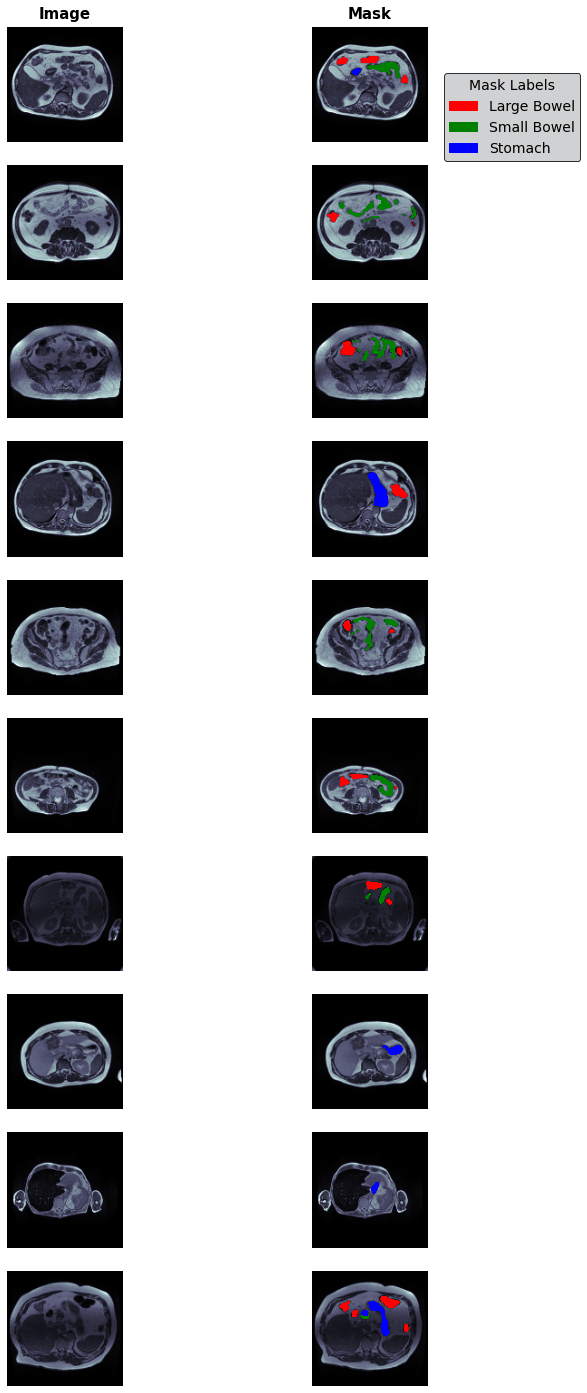

In [52]:
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=10, ncols=2)
colors = ['red','green','blue']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3 = mpl.colors.ListedColormap(colors[2])

for i in range(10):
    images, mask = X, y
    sample_img=images[i,:,:,:]
    mask1=mask[i,:,:,0]
    mask2=mask[i,:,:,1]
    mask3=mask[i,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

# METRICS

In [67]:
def dice_coef(y_true,y_pred):
    y_true_f=tf.reshape(tf.dtypes.cast(y_true, tf.float32),[-1])
    y_pred_f=tf.reshape(tf.dtypes.cast(y_pred, tf.float32),[-1])
    intersection=tf.reduce_sum(y_true_f*y_pred_f)
    sum_ = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2. * intersection + 1.) / (sum_ + 1.)


def iou_coef(y_true, y_pred):   
    y_true_f=tf.reshape(tf.dtypes.cast(y_true, tf.float32),[-1])
    y_pred_f=tf.reshape(tf.dtypes.cast(y_pred, tf.float32),[-1])
    intersection=tf.reduce_sum(y_true_f*y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    iou = (intersection+1.0) / (union+1.0)
    return iou

def bce_dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return BCE(y_true, y_pred) + (1-dice_coef(y_true, y_pred))

# MODEL ARCHITECTURE

In [68]:
def conv_block(inputs, num_filters, batchnorm ):
    x = Conv2D(num_filters, kernel_size = (3,3), padding="same",)(inputs)
    x = Activation("relu")(x)
    if batchnorm : 
        x = BatchNormalization()(x)
    x = Conv2D(num_filters, kernel_size = (3,3), padding="same")(x)
    x = Activation("relu")(x)
    if batchnorm : 
        x = BatchNormalization()(x)
    return x

def encoder_block(inputs, num_filters, dropout = False ,  batchnorm =True):
    x = conv_block(inputs, num_filters , batchnorm)
    p = MaxPool2D((2, 2))(x)
    if dropout : 
        p = Dropout(0.3)(p)
    return x, p

def decoder_block(inputs, skip_features, num_filters, dropout = False, batchnorm = True):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    if dropout : 
        x = Dropout(0.3)(x)
    x = conv_block(x, num_filters, batchnorm)
    return x

def build_unet(input_shape, dropout = False , batchnorm = True , activation = 'sigmoid'):

    inputs = Input(shape=input_shape)
    
    s0, p0 = encoder_block(inputs, 32 , dropout , batchnorm )
    s1, p1 = encoder_block(p0, 64 , dropout , batchnorm )
    s2, p2 = encoder_block(p1, 128, dropout , batchnorm  )

    b1 = conv_block(p2, 256, batchnorm)

    d3 = decoder_block(b1, s2, 128, dropout , batchnorm )
    d4 = decoder_block(d3, s1, 64, dropout , batchnorm )
    d5 = decoder_block(d4, s0, 32, dropout , batchnorm )

    outputs = Conv2D(3, 1, padding="same", activation =activation )(d5)

    model = Model(inputs, outputs, name="U-Net")

    return model

# MODEL TRAIN

In [96]:
def fit_model(model , model_name , train_dataset , validation_dataset , workers = None):
    model_path = os.path.join(MODEL_PATH, str(model_name)+'_1.h5')
    results_path = os.path.join(MODEL_PATH, 'score_'+str(model_name)+'_1.joblib')
    if os.path.isfile(model_path): 
        model = load_model(models_path+str(model_name)+'_1.h5', custom_objects={'bce_dice_loss': bce_dice_loss ,'iou_coef':iou_coef ,'dice_coef':dice_coef})
        results = load(results_path+'score_'+str(model_name)+'_1.joblib')
    else :
        callbacks = [EarlyStopping(monitor='val_loss', patience=5), 
                    ModelCheckpoint(model_path, verbose=1, save_best_only=True, save_weights_only=True)
                    ]
        if workers : 
            model.fit(x = train_dataset, epochs=CFG.EPOCHS,validation_data=validation_dataset, callbacks=callbacks,
                      workers = workers)
        else : 
            model.fit(x = train_dataset, epochs=CFG.EPOCHS, validation_data=validation_dataset, callbacks=callbacks)
 
        results = pd.DataFrame(model.history.history)

        dump(results,results_path,compress = True)
        model.save(model_path) 
    
    return model , results

In [182]:
train_generator = DataGenerator(train, batch_size = 30, subset="train", shuffle=True)
val_generator = DataGenerator(validation, batch_size =30, subset="validation", shuffle=False)

In [184]:
input_shape = CFG.IMG_SIZE
model = build_unet(input_shape, dropout = True , batchnorm = True) 

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=bce_dice_loss, metrics=[iou_coef , dice_coef])

In [185]:
model , results = fit_model(model , 'U-net_3_layers_20_epochs',train_generator,val_generator, workers = 6)

Epoch 1/20
331/331 [==============================] - ETA: 0s - loss: 1.0847 - iou_coef: 0.1160 - dice_coef: 0.1891
Epoch 1: val_loss improved from inf to 1.07254, saving model to models\U-net_3_layers_20_epochs_1.h5
331/331 [==============================] - 167s 497ms/step - loss: 1.0847 - iou_coef: 0.1160 - dice_coef: 0.1891 - val_loss: 1.0725 - val_iou_coef: 0.0028 - val_dice_coef: 0.0056
Epoch 2/20
331/331 [==============================] - ETA: 0s - loss: 0.3235 - iou_coef: 0.5490 - dice_coef: 0.7067
Epoch 2: val_loss improved from 1.07254 to 0.43357, saving model to models\U-net_3_layers_20_epochs_1.h5
331/331 [==============================] - 167s 503ms/step - loss: 0.3235 - iou_coef: 0.5490 - dice_coef: 0.7067 - val_loss: 0.4336 - val_iou_coef: 0.4408 - val_dice_coef: 0.6109
Epoch 3/20
331/331 [==============================] - ETA: 0s - loss: 0.2437 - iou_coef: 0.6411 - dice_coef: 0.7808
Epoch 3: val_loss improved from 0.43357 to 0.23436, saving model to models\U-net_3_layer

In [111]:
def plot_train(results):

    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(nrows=1, ncols=3)

    ax0 = fig.add_subplot(gs[0,0])
    _ = ax0.plot(results.index, results['loss'], label='Train_Loss')
    _ = ax0.plot(results.index, results['val_loss'], label='Val_Loss')

    plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.legend()

    ax1 = fig.add_subplot(gs[0,1])
    _ = ax1.plot(results.index, results['iou_coef'], label='Train_iou_coef')
    _ = ax1.plot(results.index, results['val_iou_coef'], label='Val_iou_coef')

    plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();

    ax2 = fig.add_subplot(gs[0,2])
    _ = ax2.plot(results.index, results['dice_coef'], label='Train_dice_coef')
    _ = ax2.plot(results.index, results['val_dice_coef'], label='Val_dice_coef')


    plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 
    

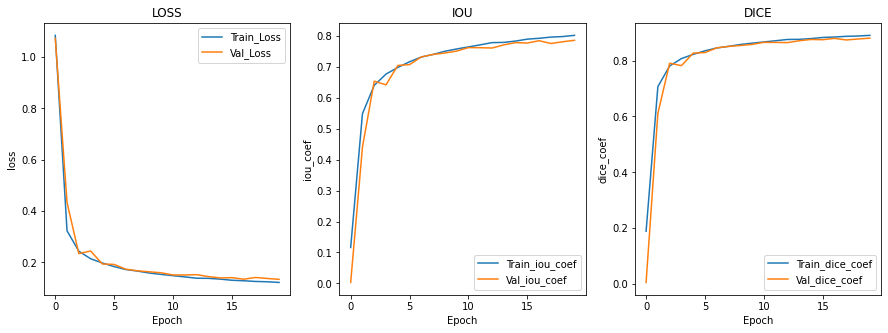

In [186]:
plot_train(results)

# INFERENCE

In [187]:
test_generator = DataGenerator(test, batch_size =5, subset="test", shuffle=False)

In [188]:
X_test, y_test = test_generator[0]

In [189]:
X_test.shape, y_test.shape

(TensorShape([5, 128, 128, 1]), TensorShape([5, 128, 128, 3]))

In [190]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 284ms/step


In [234]:
y_pred1 = (y_pred>0.5).astype(dtype='uint8')

In [235]:
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test, y_pred1)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.88626564


In [212]:
def mask_extract(img):
    
    mask1 = img[:,:,0]
    mask2= img[:,:,1]
    mask3= img[:,:,2]
    
    only_mask1= np.ma.masked_where(mask1 == False, mask1)
    only_mask2= np.ma.masked_where(mask2 == False, mask2)
    only_mask3= np.ma.masked_where(mask3 == False, mask3)
    
    return only_mask1, only_mask2, only_mask3

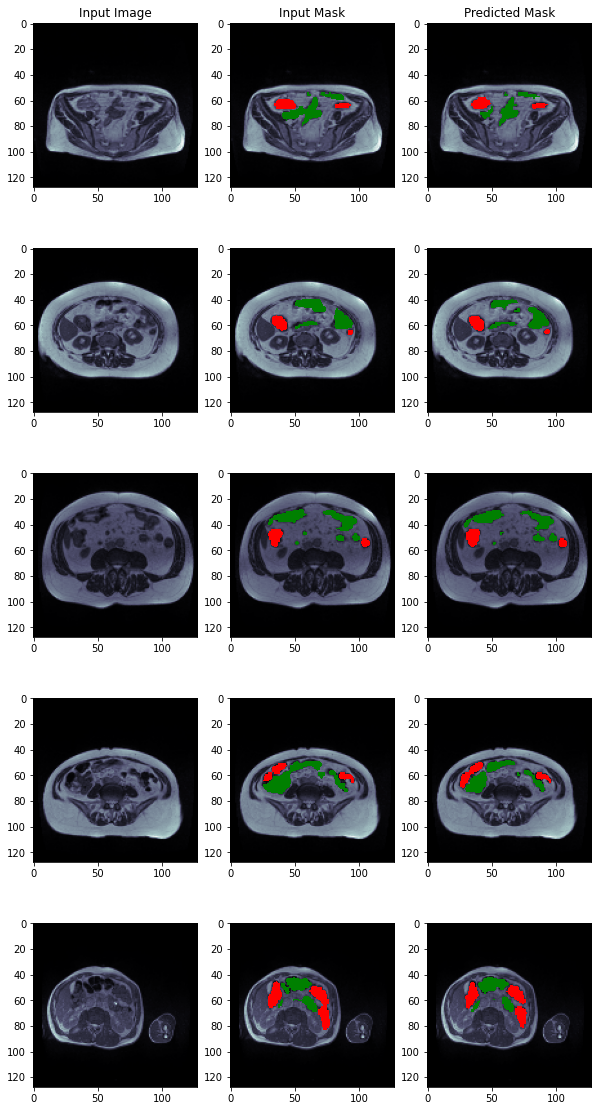

In [233]:
fig = plt.figure(figsize=(10, 20))
gs = gridspec.GridSpec(nrows=len(X_test), ncols=3)

cmap1 = mpl.colors.ListedColormap('red')
cmap2 = mpl.colors.ListedColormap('green')
cmap3 = mpl.colors.ListedColormap('blue')

for i in range(len(X_test)):

    ax0 = fig.add_subplot(gs[i,0])
    _ = ax0.imshow(X_test[i], cmap='bone')
    
    if i == 0:
        plt.title('Input Image')
    
    mask1, mask2, mask3 = mask_extract(y_test[i])
    
    ax1 = fig.add_subplot(gs[i,1])
    _ = ax1.imshow(X_test[i], cmap='bone')
    _ = ax1.imshow(mask1, cmap=cmap1, alpha=1)
    _ = ax1.imshow(mask2, cmap=cmap2, alpha=1)
    _ = ax1.imshow(mask3, cmap=cmap3, alpha=1)

    if i == 0:
        plt.title('Input Mask')
    
    mask1, mask2, mask3 = mask_extract(y_pred1[i])
        
    ax2 = fig.add_subplot(gs[i,2])
    _ = ax2.imshow(X_test[i], cmap='bone')
    _ = ax2.imshow(mask1, cmap=cmap1, alpha=1)
    _ = ax2.imshow(mask2, cmap=cmap2, alpha=1)
    _ = ax2.imshow(mask3, cmap=cmap3, alpha=1)

    if i == 0:
        plt.title('Predicted Mask')